In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# First, we load the SUSY dataset

In [21]:
susyDataset = "path/to/SUSYnormalized.csv"
df=pd.read_csv(susyDataset, sep=',',header=None)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-1.0,-0.262865,1.021251,-1.349137,-0.239498,-0.977499,0.728882,-0.610697,0.167679,-0.450072,-0.141682,0.364601,-0.457305,-1.000443,-0.171380,0.377758,-0.285896,-0.328067,-0.696975
1,1.0,1.636697,0.011421,0.099661,2.853544,0.342602,-1.452455,0.775942,-1.344975,-0.611879,-0.095254,1.657651,1.821243,-0.219609,-1.164297,1.755913,-0.999041,0.478676,0.202879
2,-1.0,-0.584556,1.818725,0.356350,-0.650177,-0.020800,-0.488248,-0.451181,1.544893,-0.102835,-0.221186,-0.320394,-0.388119,-0.299458,0.620959,-0.331641,0.252499,-0.550372,-0.818578
3,-1.0,-0.823545,-0.063513,0.424605,-0.753841,1.232784,-1.366795,-0.171353,0.236254,-0.628507,1.024815,-0.785426,-0.723257,0.025393,-0.875569,-0.741559,-0.844548,1.142209,0.170621
4,1.0,1.605432,0.235464,1.281689,0.415985,0.708642,0.145232,-0.314995,-0.305751,-0.817995,-0.278597,0.866632,0.717818,-0.392766,0.400897,0.597123,0.538697,-1.636912,0.894790


In [38]:
Y = df.iloc[:,0].to_numpy()
X = df.iloc[:,1:].to_numpy()
print(X.shape, Y.shape)

paramFrac = 0.2
trainFrac = 0.4
testfrac = 0.2
globalfrac = 0.4

n = 50000
nTrain = 50000#int(n*trainFrac)
nTest = 100000#int(n*testfrac)
nGlobal = 100000#int(n*globalfrac)
nParam = 2000#int(n*paramFrac)

Xglobal = X[nTrain + nTest:nTrain + nTest + nGlobal]
Yglobal = Y[nTrain + nTest:nTrain + nTest + nGlobal]
Xtest = X[nTrain:nTrain + nTest]
Ytest = Y[nTrain:nTrain + nTest]
Xparam = X[nTrain + nTest + nGlobal:nTrain + nTest + nGlobal + nParam]
Yparam = Y[nTrain + nTest + nGlobal:nTrain + nTest + nGlobal + nParam]
X = X[:nTrain]
Y = Y[:nTrain]

print(X.shape, Y.shape, Xglobal.shape, Yglobal.shape, Xtest.shape, Ytest.shape, Xparam.shape, Yparam.shape)

(3698112, 18) (3698112,)
(50000, 18) (50000,) (100000, 18) (100000,) (100000, 18) (100000,) (2000, 18) (2000,)


# A little parameter evaluation for Decision Trees

In [39]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':list(range(1,10)), 'min_samples_split':list(range(2,50, 4)), 'min_samples_leaf' : list(range(1,50, 5)), 'criterion' : ['gini', 'entropy']}

dt = DecisionTreeClassifier()

clf = GridSearchCV(dt, parameters)
clf.fit(Xparam, Yparam)

optParams = clf.best_params_
print(optParams)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 26, 'min_samples_split': 14}


# Divide data into local datasets

Training data is separated by drawing half of each local dataset uniform at random and half of the dataset based on the value of one selected feature.

For the selected feature col (I have chosen feature 0 rather randomly, here), its values are binned by frequency (each bin contains an equal amount of data points) and each bin is appended to one local dataset. Thus, half of each local dataset is uniform, the other half has one particular feature value in a fixed range that is different from all other local datasets. Thus, there is some mild form on non-iid-ness in the distribution of X.

In [40]:
def equalFrequencyIntervals(vals, bins):
    n = len(vals)
    intervals = np.interp(np.linspace(0, n, bins + 1), np.arange(n), np.sort(vals))
    intervals[-1] += 0.00001 #this should solve rounding errors
    return intervals

def getLearner(i, intervals, X, col):
    for j in range(len(intervals)):
        if X[i,col] < intervals[j]:
            return j - 1
    print(X[i,col], intervals)

def distributeDataset(X, Y, col, num_learners, frac_colBin = 0.5):
    n = Y.shape[0]
    n_colBin = int(n*frac_colBin)
    
    
    indices = list(range(n))
    random.shuffle(indices)
    
    indColBin    = indices[:n_colBin]
    indNonColBin = indices[n_colBin:]
    
    Xs = np.array_split(X[indNonColBin,:], num_learners)    
    Ys = np.array_split(Y[indNonColBin], num_learners)    
    
    
    vals = X[indColBin,col]
    intervals = equalFrequencyIntervals(vals, num_learners)
    
    Idxs = [[] for _ in range(num_learners)]
    count = 0
    for i in indColBin:
        l = getLearner(i, intervals, X, col)
        Idxs[l].append(i)
        count += 1
        
        
    for l in range(num_learners):
        Xcolbin = X[Idxs[l],:]
        Ycolbin = Y[Idxs[l]]
        Xs[l] = np.vstack([Xs[l],Xcolbin])
        Ys[l] = np.hstack([Ys[l],Ycolbin])
    return Xs, Ys 

In [41]:
num_learners = 50
col          = 0

Xs, Ys = distributeDataset(X,Y, col, num_learners)
for l in range(num_learners):
    print(Xs[l].shape, Ys[l].shape)

(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)
(1000, 18) (1000,)


# Compute Test Accuracies

For a given number of examples per learner, compute the test accuracy on the local decision tree, then label global data, retrain decision trees and compute test accuracies again.

In [42]:
def computeAccsForSamplesPerLearner(examplesPerLearner, Xs, Ys, theta = 0.1):
    #train local models and compute their test accuracy:
    testACC = 0.0
    learners = []
    for l in range(num_learners):
        Xl = Xs[l][:examplesPerLearner]
        Yl = Ys[l][:examplesPerLearner]
        clf = DecisionTreeClassifier(**optParams)
        clf.fit(Xl, Yl)
        learners.append(clf)

        ypred = clf.predict(Xtest)
        testACC += accuracy_score(Ytest, ypred)
    testACC = testACC / float(num_learners)
    
    #use local models to obtain labels for global dataset:
    thetaPos = num_learners * (1-theta) 
    thetaNeg = num_learners * theta
    globalPreds = []
    for l in range(num_learners):
        Ypred_global = learners[l].predict(Xglobal)
        globalPreds.append(Ypred_global)
    globalPreds = np.sum(np.array(globalPreds), axis=0) #take the sum to get an estimate of the consensus (if sum = 5, all learners say it's 1, if sum = 0 all say it's 0)

    #we now want to remove those data points from the global set for which the local models are not agreeing very much
    confidentGlobalPreds = []
    confidentIdxs = []
    for i in range(globalPreds.shape[0]):
        pred = globalPreds[i]
        if pred >= thetaPos:
            confidentGlobalPreds.append(1.0)
            confidentIdxs.append(i)
        elif pred >= thetaPos:
            confidentGlobalPreds.append(0.0)
            confidentIdxs.append(i)
    confidentGlobalPreds = np.array(confidentGlobalPreds)
    print(confidentGlobalPreds.shape)

    Xconfglobal = Xglobal[confidentIdxs,:]
    Yconfglobal = Yglobal[confidentIdxs]
    
    #retrain local models using global dataset
    testACCglobal = 0.0
    learnersGlobal = []
    for l in range(num_learners):
        Xl = np.vstack([Xs[l][:examplesPerLearner], Xconfglobal])
        Yl = np.hstack([Ys[l][:examplesPerLearner], confidentGlobalPreds])
        clf = DecisionTreeClassifier(**optParams)
        clf.fit(Xl, Yl)
        learnersGlobal.append(clf)

        ypred = clf.predict(Xtest)
        testACCglobal += accuracy_score(Ytest, ypred)
    testACCglobal = testACCglobal / float(num_learners)
    
    return testACC, testACCglobal


In [49]:
exPerLearnerList = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200, 250, 300, 400, 500, 
                    600, 700, 900, 1000, 1200, 1300, 1500, 1700, 2000, 2500, 3000, 4000, 5000]

globalAccPerTheta = []
testACCs = []
thetas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for theta in thetas:
    testACCs = []
    testACCsglobal = []
    for n in exPerLearnerList:
        testACC, testACCglobal = computeAccsForSamplesPerLearner(n, Xs, Ys, theta = theta)
        testACCs.append(testACC)
        testACCsglobal.append(testACCglobal)
    globalAccPerTheta.append(testACCsglobal)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(9389,)
(6704,)
(12030,)
(5531,)
(5995,)
(8728,)
(2617,)
(7569,)
(7174,)
(5373,)
(8040,)
(9372,)
(11283,)
(11046,)
(9988,)
(11703,)
(12310,)
(12232,)
(12232,)
(12219,)
(12310,)
(12219,)
(12303,)
(12219,)
(12303,)
(12219,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(17487,)
(17516,)
(17169,)
(14648,)
(13467,)
(13843,)
(12993,)
(12015,)
(12631,)
(12130,)
(13605,)
(15213,)
(15545,)
(15681,)
(15492,)
(15935,)
(16832,)
(16809,)
(16813,)
(16845,)
(16816,)
(16832,)
(16796,)
(16793,)
(16829,)
(16797,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(21292,)
(21230,)
(19699,)
(17266,)
(16272,)
(16610,)
(17037,)
(17406,)
(17521,)
(15649,)
(18413,)
(20284,)
(19710,)
(19421,)
(19658,)
(20116,)
(21159,)
(21187,)
(21166,)
(21159,)
(21173,)
(21135,)
(21132,)
(21144,)
(21158,)
(21156,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(23006,)
(22711,)
(21071,)
(19541,)
(18067,)
(18556,)
(19181,)
(20891,)
(20693,)
(18066,)
(20366,)
(22501,)
(21766,)
(21327,)
(21779,)
(22402,)
(23554,)
(23565,)
(23538,)
(23594,)
(23560,)
(

# Finally, plot the results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()
ax.plot(exPerLearnerList, testACCs, label='test accuracies')
ax.plot(exPerLearnerList, testACCsglobal, label='test accuracies with global data')
ax.set_title('Global data size = '+str(nGlobal))
plt.legend()
plt.savefig("accuraciesForDataPerLearner.png", dpi=300)
plt.show()

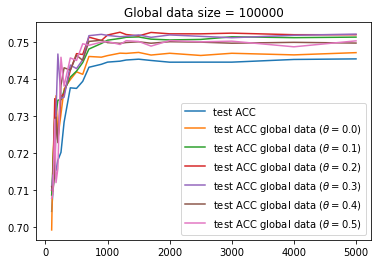

In [58]:
k = 10

fig, ax = plt.subplots()
ax.plot(exPerLearnerList[k:], testACCs[k:], label='test ACC')
for i in range(len(thetas)):
    theta = thetas[i]
    globalACCs = globalAccPerTheta[i]
    ax.plot(exPerLearnerList[k:], globalACCs[k:], label=r'test ACC global data $(\theta='+str(theta)+')$')
ax.set_title('Global data size = '+str(nGlobal))
plt.legend()
plt.savefig("accuraciesForDataPerLearnerPerTheta.png", dpi=300)
plt.show()